# Deep Unsupervised Hashing - AI Project
---

In [ ]:
import re
import os
import shutil
import random
from datetime import datetime

import cv2
import tqdm
import numpy
import requests
import tensorflow
from tensorflow import keras
from matplotlib import pyplot
from google.colab import drive
from PIL import Image, ImageFile, ImageFilter, ImageDraw, ImageFont

ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
WORK_DIRECTORY    = os.path.join("/", "content")
DRIVE_DIRECTORY   = os.path.join("/", "content", "drive")
PROJECT_DIRECTORY = os.path.join("/", "content", "drive", "MyDrive", "AI Project - DeepHash")

- ##### Initialize connection with Google Drive for storage:

In [ ]:
drive.mount(DRIVE_DIRECTORY, force_remount = True)
os.chdir(PROJECT_DIRECTORY)

Mounted at /content/drive


## Data Preprocessing:

- ##### Download the dataset images (w/o labels) from the dataset homepage:

In [ ]:
IMAGES_ZIP_URL = "https://press.liacs.nl/mirflickr/mirflickr1m.v3b/images{}.zip"
CHUNK_SIZE     = 1048576
MAX_FILE_COUNT = 10

if not os.path.exists(PROJECT_DIRECTORY):
  os.makedirs(PROJECT_DIRECTORY)

for i in range(MAX_FILE_COUNT):
  response = requests.get(IMAGES_ZIP_URL.format(i), stream = True)
  size    = int(response.headers['Content-Length'])
  outfile = os.path.join(PROJECT_DIRECTORY, response.url.split('/')[-1])
  with tqdm.tqdm(total=size, unit='B', unit_scale=True, unit_divisor=1024) as pbar:
    with open(outfile, 'wb') as out:
      for chunk in response.iter_content(chunk_size = CHUNK_SIZE):
        out.write(chunk); pbar.update(len(chunk))
    print('\n', end='')

- ##### Extract the images:

In [ ]:
os.chdir(WORK_DIRECTORY)
def unzip(file):
  !mkdir -p "images/original"
  !unzip "/content/drive/MyDrive/AI Project - DeepHash/{file}.zip" -d "images/original"

In [ ]:
unzip("images0")
# unzip("images1")

- ##### Move images from clustered folders to a single folder:

In [ ]:
SOURCE_PATH      = "images/original/images/{}"
SOURCE_PATH_ROOT = os.path.dirname(SOURCE_PATH)
DESTINATION_PATH = "images/original"

if os.path.exists(SOURCE_PATH_ROOT):
  for i in range(100):
    source_dir = SOURCE_PATH.format(i)
    if not os.path.exists(source_dir): continue

    files = os.listdir(source_dir)
    for i in tqdm.trange(len(files)):
      dest_file = os.path.join(DESTINATION_PATH, files[i])
      if os.path.exists(dest_file): os.remove(dest_file)
      shutil.move(os.path.join(source_dir, files[i]), DESTINATION_PATH)
    os.rmdir(source_dir)

if os.path.exists(SOURCE_PATH_ROOT) and not os.listdir(SOURCE_PATH_ROOT):
  os.rmdir(SOURCE_PATH_ROOT)

100%|██████████| 10000/10000 [00:00<00:00, 17454.25it/s]


- ##### Generate attacked variants of images from the dataset:

In [ ]:
def image_processor(operation, root = "images"):
  def decorator(processing_function):
    def wrapper(save_prefix = "", save_suffix = "", *args, **kwargs):
      dest_dir = os.path.join(root, (save_prefix or "") + operation + (save_suffix or ""))
      if not os.path.exists(dest_dir): os.makedirs(dest_dir)
      def wrapper_invoker(image):
        dest_file = os.path.join(dest_dir, os.path.basename(image.filename))
        if not os.path.exists(dest_file):
          result, *options = processing_function(image, *args, **kwargs)
          result = result.resize((224, 224))
          result.save(dest_file, **(options[0] if options else {}))
      return wrapper_invoker
    return wrapper
  return decorator

In [ ]:
@image_processor("blur")
def blur_image(image, radius):
  return (image.filter(ImageFilter.GaussianBlur(radius)), )

@image_processor("crop")
def crop_image(image, crop_ratio):
  hleft = crop_ratio * image.width
  vtop  = crop_ratio * image.height
  crop_box = (hleft, vtop, image.width-hleft, image.height-vtop)
  return (image.crop(crop_box), )

@image_processor("compress")
def compress_image(image, quality):
  return (image, { 'quality': quality })

@image_processor("flip")
def flip_image(image, method):
  return (image.transpose(method), )

@image_processor("rotate")
def rotate_image(image, angle):
  return (image.rotate(angle), )

@image_processor("scale")
def scale_image(image, factor, resample = Image.BILINEAR):
  new_width = int(image.width * factor)
  new_height = int(image.height * factor)
  return (image.resize((new_width, new_height), resample), )

@image_processor("gamma")
def adjust_gamma(image, gamma):
  factor = 1.0 / gamma
  gamma_table = numpy.fromiter(
    ( pow((i/255),factor)*255 for i in range(0, 256) ), "uint8"
  )
  image_array = cv2.cvtColor(numpy.array(image), cv2.COLOR_RGB2BGR)
  image_array = cv2.LUT(image_array, gamma_table)
  return (Image.fromarray(cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB)), )

@image_processor("histogram_equalize")
def equalize_histogram(image):
  image_array = cv2.cvtColor(numpy.array(image), cv2.COLOR_RGB2YCR_CB)
  image_array[:,:,0] = cv2.equalizeHist(image_array[:,:,0])
  return (Image.fromarray(cv2.cvtColor(image_array, cv2.COLOR_YCR_CB2RGB)), )

@image_processor("occlude")
def occlude_image(image, font):
  text = datetime.today().isoformat()
  x = random.randint(0, int(0.75 * image.width))
  y = random.randint(0, int(0.30 * image.height))
  r = random.randint(128, 255)
  g = random.randint(128, 255)
  b = random.randint(128, 255)
  image_copy = image.copy()
  canvas = ImageDraw.Draw(image_copy)
  canvas.text((x, y), text, (r, g, b), font = font)
  return (image_copy, )

@image_processor("noise_salt_and_pepper")
def add_salt_and_pepper(image, factor, ratio = 0.5):
  image_array = numpy.array(image)
  salt_size = int(numpy.ceil(factor * ratio * image_array.size))
  coords = tuple(
    numpy.random.randint(dimension, size = salt_size)
    for dimension in image_array.shape
  )
  image_array[coords] = 1
  pepper_size = int(numpy.ceil(factor * (1.0 - ratio) * image_array.size))
  coords = tuple(
    numpy.random.randint(dimension, size = pepper_size)
    for dimension in image_array.shape
  )
  image_array[coords] = 0
  return (Image.fromarray(image_array), )

@image_processor("base")
def prepare_image(image):
  return (image, )

In [ ]:
FONT_PATH = "/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf"
font = ImageFont.truetype(FONT_PATH, 24)

OPERATIONS = {
    'base': prepare_image(), 
    'blur': blur_image(radius = 5),
    'crop': crop_image(crop_ratio = 0.05),
    'compress': compress_image(quality = 10),
    'flip_vertical': flip_image(
      method = Image.FLIP_TOP_BOTTOM,
      save_suffix = "_vertical"
    ),
    'flip_horizontal': flip_image(
      method = Image.FLIP_LEFT_RIGHT,
      save_suffix = "_horizontal"
    ),
    'rotate_plus': rotate_image(
      angle = 5, save_suffix = "_plus"
    ),
    'rotate_minus': rotate_image(
      angle = -5, save_suffix = "_minus"
    ),
    'downscale': scale_image(
      factor = 0.5, save_prefix = "down"
    ),
    'gamma_increase': adjust_gamma(
      gamma = 1.5, save_suffix = "_increase"
    ),
    'gamma_decrease': adjust_gamma(
      gamma = 0.5, save_suffix = "_decrease"
    ),
    'histogram_equalize': equalize_histogram(),
    'occlude': occlude_image(font = font),
    'noise_salt_and_pepper': add_salt_and_pepper(factor = 0.05)
}

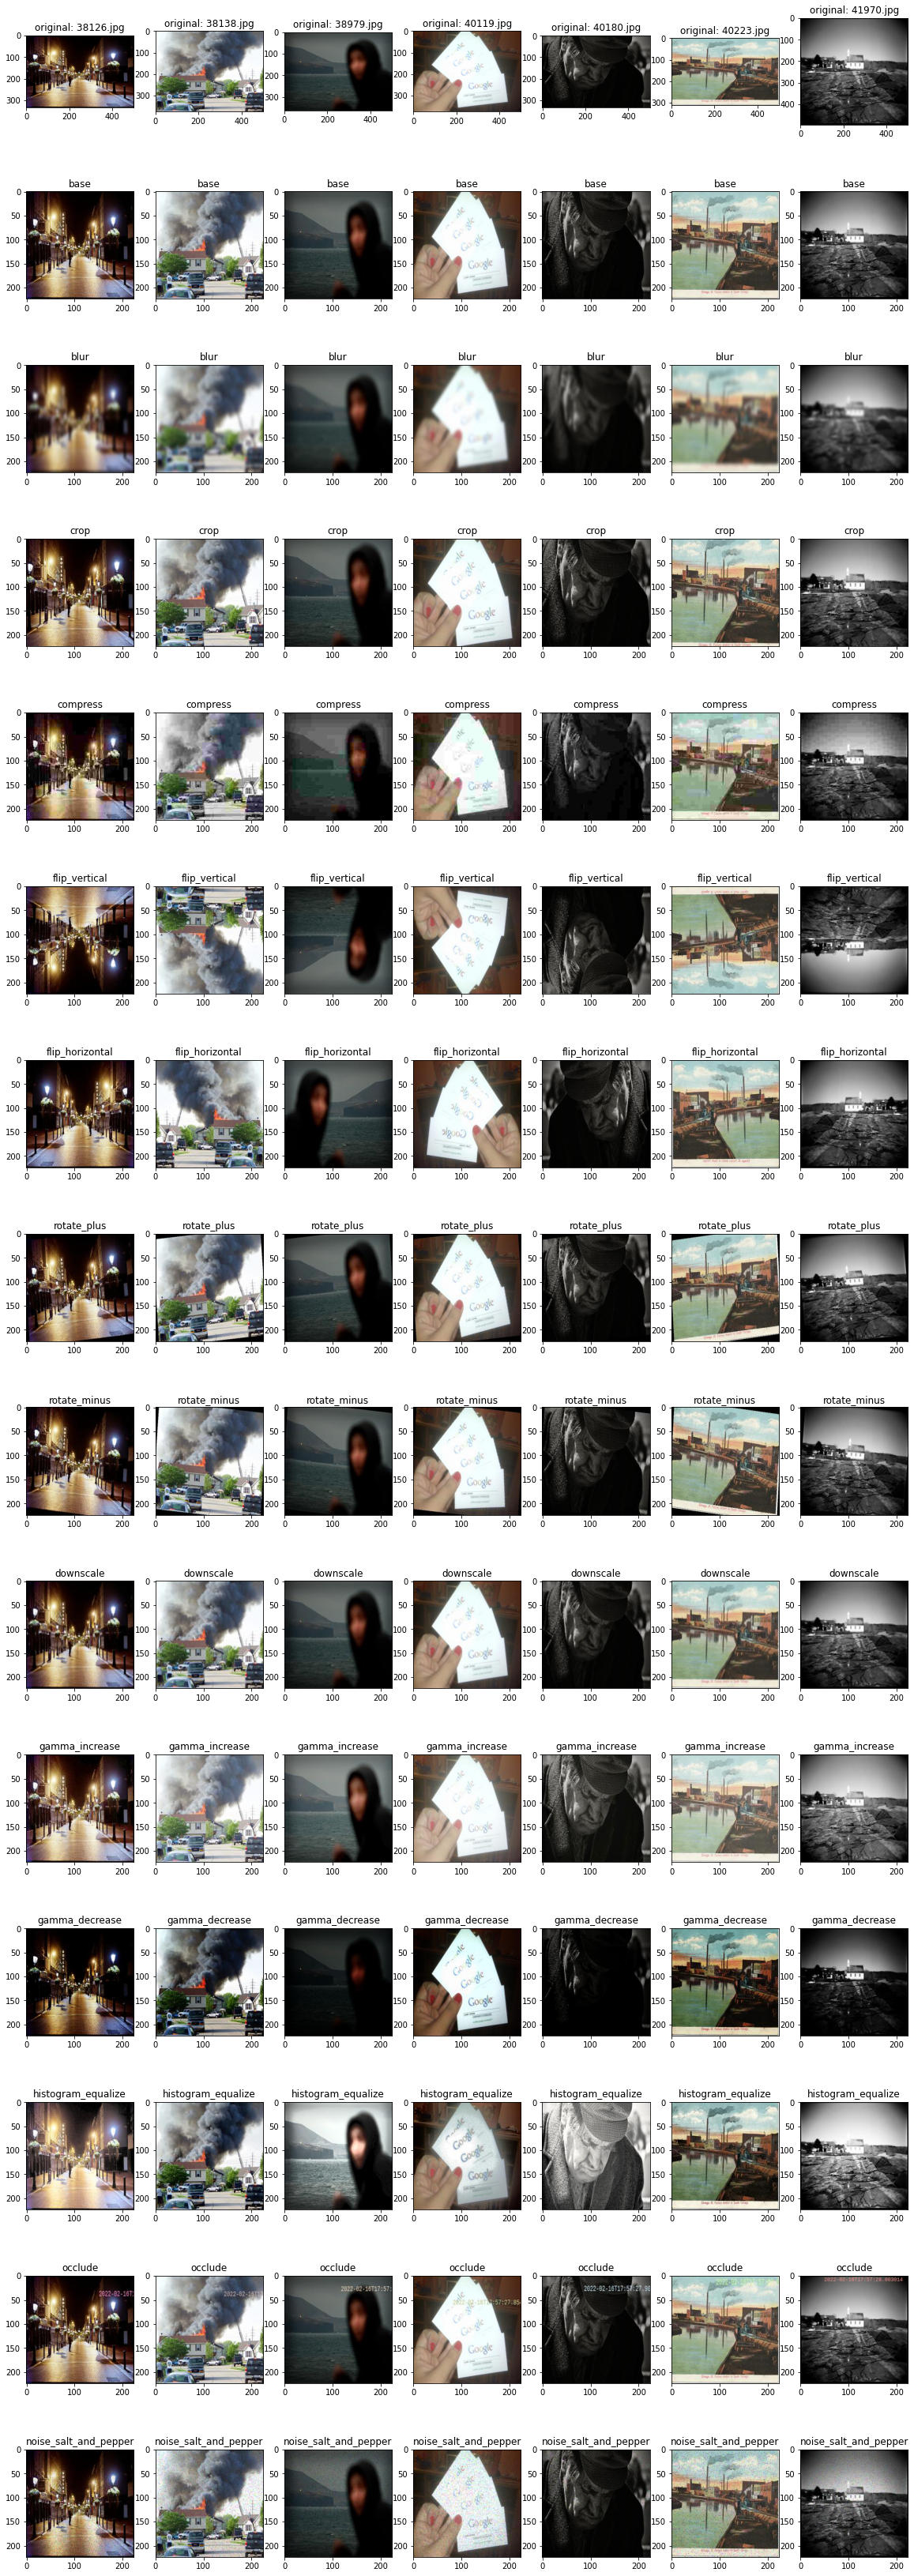

In [ ]:
IMAGES = [ 38126, 38138, 38979, 40119, 40180, 40223, 41970 ]

pyplot.figure(figsize = (20, 60))
rows    = len(OPERATIONS.keys()) + 1
columns = len(IMAGES)

for j, image in enumerate(IMAGES, 1):
  original_image = Image.open(f"images/original/{image}.jpg")
  pyplot.subplot(rows, columns, j)
  pyplot.title(f"original: {image}.jpg")
  pyplot.imshow(original_image)
for i, operation in enumerate(OPERATIONS, 1):
  operation_fx = OPERATIONS[operation]
  if operation_fx:
    for j, image in enumerate(IMAGES, 1):
      original_image = Image.open(f"images/original/{image}.jpg")
      operation_fx(original_image)
      new_image = Image.open(f"images/{operation}/{image}.jpg")
      pyplot.subplot(rows, columns, i * columns + j)
      pyplot.title(operation)
      pyplot.imshow(new_image)

In [ ]:
from multiprocess.pool import ThreadPool

def process_set(set_index = 0):
  images = os.listdir("images/original")
  SAVE_DIRECTORY = "/content/drive/MyDrive/AI Project - DeepHash"
  suffix = f"_{set_index}" if set_index else ""

  for operation in OPERATIONS:
    operation_archive = os.path.join(SAVE_DIRECTORY, f"images_{operation}{suffix}.tar.gz")
    if os.path.exists(operation_archive): continue

    print("> Generating", operation, "variants:")
    def apply_operation(image):
      image_obj = Image.open(os.path.join("images/original", image))
      try:
        OPERATIONS[operation](image_obj)
      except OSError as e:
        print(image)
        raise e
    with ThreadPool() as pool:
      pool_result = pool.imap_unordered(apply_operation, images)
      for _ in tqdm.tqdm(pool_result, total = len(images)): pass
    archive = shutil.make_archive(
      f"/content/images_{operation}{suffix}", "gztar",
      root_dir = os.path.join("images", operation)
    )
    shutil.move(archive, SAVE_DIRECTORY)

In [ ]:
process_set(1)

- ##### Load processed data for training:

In [ ]:
!rm -rf "/content/images/original"

In [ ]:
def recover_operation_files(operation, set_index = 0):
  operation_dir = os.path.join("/content/images", operation)
  suffix = f"_{set_index}" if set_index else ""
  print(f"> Extracting 'images_{operation}{suffix}.tar.gz' ...")
  archive = os.path.join(PROJECT_DIRECTORY, f"images_{operation}{suffix}.tar.gz")
  if os.path.exists(archive):
    if not os.path.exists(operation_dir): os.makedirs(operation_dir)
    !tar -zxf "{archive}" -C {operation_dir} --checkpoint=.1000

In [ ]:
recover_operation_files("base")
# recover_operation_files("base", 1)
# for operation in os.listdir("/content/images"):
#   if operation == "original": continue
#   else recover_operation_files(operation)

> Extracting 'images_base.tar.gz' ...
..............................................................................................................

In [ ]:
len(os.listdir("/content/images/base"))

100003

## Preparing the Dataset for Model Training:

In [ ]:
IMAGE_SHAPE  = (224, 224, 3)

- ##### Formatting the dataset; and generating training, test and validation splits in the filesystem:

In [ ]:
def fix_dataset_tree(operation_dir, train_exist, test_exist, validation_exist):
  training_path   = os.path.join(operation_dir, "train", "0")
  testing_path    = os.path.join(operation_dir, "test", "0")
  validation_path = os.path.join(operation_dir, "validation", "0")
  if train_exist:
    for file in tqdm.tqdm(os.listdir(training_path)):
      shutil.move(os.path.join(training_path, file), operation_dir)
    os.rmdir(training_path)
    os.rmdir(os.path.dirname(training_path))
  if test_exist:
    for file in tqdm.tqdm(os.listdir(testing_path)):
      shutil.move(os.path.join(testing_path, file), operation_dir)
    os.rmdir(testing_path)
    os.rmdir(os.path.dirname(testing_path))
  if validation_exist:
    for file in tqdm.tqdm(os.listdir(validation_path)):
      shutil.move(os.path.join(validation_path, file), operation_dir)
    os.rmdir(validation_path)
    os.rmdir(os.path.dirname(validation_path))

def prepare_datasets(ratio, operation):
  operation_dir = os.path.join("/content/images", operation)
  if not os.path.exists(operation_dir): return
  
  training_path   = os.path.join(operation_dir, "train", "0")
  testing_path    = os.path.join(operation_dir, "test", "0")
  validation_path = os.path.join(operation_dir, "validation", "0")

  train_exist      = os.path.exists(training_path)
  test_exist       = os.path.exists(testing_path)
  validation_exist = os.path.exists(validation_path)
  
  # if train_exist and test_exist and validation_exist: return
  fix_dataset_tree(operation_dir, train_exist, test_exist, validation_exist)
  assert len(ratio) == 3 and sum(ratio) == 1
  
  files = os.listdir(operation_dir)
  random.shuffle(files)

  os.makedirs(training_path)
  os.makedirs(testing_path)
  os.makedirs(validation_path)

  train_len          = int(ratio[0] * len(files))
  train_and_test_len = train_len + int(ratio[1] * len(files))
  train_files        = files[ : train_len]
  test_files         = files[train_len : train_and_test_len]
  validation_files   = files[train_and_test_len : ]
  for file in tqdm.tqdm(train_files):
    shutil.move(os.path.join(operation_dir, file), training_path)
  for file in tqdm.tqdm(test_files):
    shutil.move(os.path.join(operation_dir, file), testing_path)
  for file in tqdm.tqdm(validation_files):
    shutil.move(os.path.join(operation_dir, file), validation_path)

In [ ]:
prepare_datasets(( 0.6, 0.2, 0.2 ), "base")

100%|██████████| 20000/20000 [00:01<00:00, 18758.08it/s]


- ##### Preparing the data generator to effectively pass images to the model:

In [ ]:
data_generator = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1.0/255,
    horizontal_flip = True,
    vertical_flip = True,
    rotation_range = 5,
    brightness_range = [ 0.5, 1.5 ],
)

data_generator_no_augment = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1.0/255,
)

def get_datasets(operation, augment = True, batch_sizes = ( 200, 100, 100 )):
  operation_dir = os.path.join("/content/images", operation)
  
  training_path   = os.path.join(operation_dir, "train")
  testing_path    = os.path.join(operation_dir, "test")
  validation_path = os.path.join(operation_dir, "validation")

  if augment:
    train_dataset = data_generator.flow_from_directory(
        training_path, class_mode = 'input',
        target_size=IMAGE_SHAPE[:-1], batch_size = batch_sizes[0]
    )
    validation_dataset = data_generator.flow_from_directory(
        validation_path, class_mode = 'input',
        target_size=IMAGE_SHAPE[:-1], batch_size = batch_sizes[1]
    )
    testing_dataset = data_generator.flow_from_directory(
        testing_path, class_mode = 'input',
        target_size=IMAGE_SHAPE[:-1], batch_size = batch_sizes[2]
    )
  else:
    train_dataset = data_generator_no_augment.flow_from_directory(
        training_path, class_mode = 'input',
        target_size=IMAGE_SHAPE[:-1], batch_size = batch_sizes[0]
    )
    validation_dataset = data_generator_no_augment.flow_from_directory(
        validation_path, class_mode = 'input',
        target_size=IMAGE_SHAPE[:-1], batch_size = batch_sizes[1]
    )
    testing_dataset = data_generator_no_augment.flow_from_directory(
        testing_path, class_mode = 'input',
        target_size=IMAGE_SHAPE[:-1], batch_size = batch_sizes[2]
    )
  return train_dataset, testing_dataset, validation_dataset

In [ ]:
train, test, validation = get_datasets("base", batch_sizes = (16, 8, 8))

Found 60000 images belonging to 1 classes.
Found 20000 images belonging to 1 classes.
Found 20000 images belonging to 1 classes.


## Building the Primary Model:

In [ ]:
HASH_SIZE    = 256
FILTER_SIZES = (16, 32, 64, 64, 64)

- ##### Building the model architecture:

In [ ]:
def get_autoencoder_components():
  encoder_input = keras.layers.Input(shape = IMAGE_SHAPE)
  sub_layer = encoder_input
  for filter_dims in FILTER_SIZES:
    kernel_size = 3
    # Convolution
    sub_layer = keras.layers.Conv2D(
      filters = filter_dims, kernel_size = kernel_size,
      padding = 'same', activation = 'relu'
    )(sub_layer)
    # Batch Normalization
    sub_layer = keras.layers.BatchNormalization()(sub_layer)
    # Max Pooling
    sub_layer = keras.layers.MaxPooling2D()(sub_layer)
  target_reshape    = sub_layer.shape
  sub_layer = keras.layers.Flatten()(sub_layer)
  target_flat_shape = sub_layer.shape
  encoder_output = keras.layers.Dense(HASH_SIZE, activation = 'tanh')(sub_layer)
  encoder = keras.Model(
    name = "encoder",
    inputs = encoder_input, outputs = encoder_output
  )
  binary_regularization_loss = 0.01 * keras.backend.mean(
    keras.backend.sum(
      keras.backend.abs(keras.backend.abs(encoder_output) - 1),
      axis = -1
    ),
    axis = -1
  )
  encoder.add_loss(binary_regularization_loss)
  encoder.add_metric(
    binary_regularization_loss, name = "binary_regularization"
  )

  decoder_input = keras.layers.Input((HASH_SIZE, ))
  sub_layer = keras.layers.Dense(target_flat_shape[-1])(decoder_input)
  sub_layer = keras.layers.Reshape(target_shape = target_reshape[1:])(sub_layer)
  for filter_dims in FILTER_SIZES[::-1]:
    sub_layer = keras.layers.Conv2DTranspose(
      filters = filter_dims,
      kernel_size = 3,
      strides = 2,
      padding = 'same',
      activation = 'relu'
    )(sub_layer)
  decoder_output = keras.layers.Conv2DTranspose(
    filters = 3,
    kernel_size = 3,
    padding = 'same',
    activation = None
  )(sub_layer)
  decoder = keras.Model(
    name = "decoder",
    inputs = decoder_input, outputs = decoder_output
  )

  return encoder, decoder

In [ ]:
encoder, decoder = get_autoencoder_components()
encoder.summary()
decoder.summary()

In [ ]:
input = keras.layers.Input(shape = IMAGE_SHAPE)
encoder_out = encoder(input)
decoder_out = decoder(encoder_out)
autoencoder = keras.Model(inputs = input, outputs = decoder_out)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 encoder (Functional)        (None, 256)               901472    
                                                                 
 decoder (Functional)        (None, 224, 224, 3)       940259    
                                                                 
Total params: 1,841,731
Trainable params: 1,841,251
Non-trainable params: 480
_________________________________________________________________


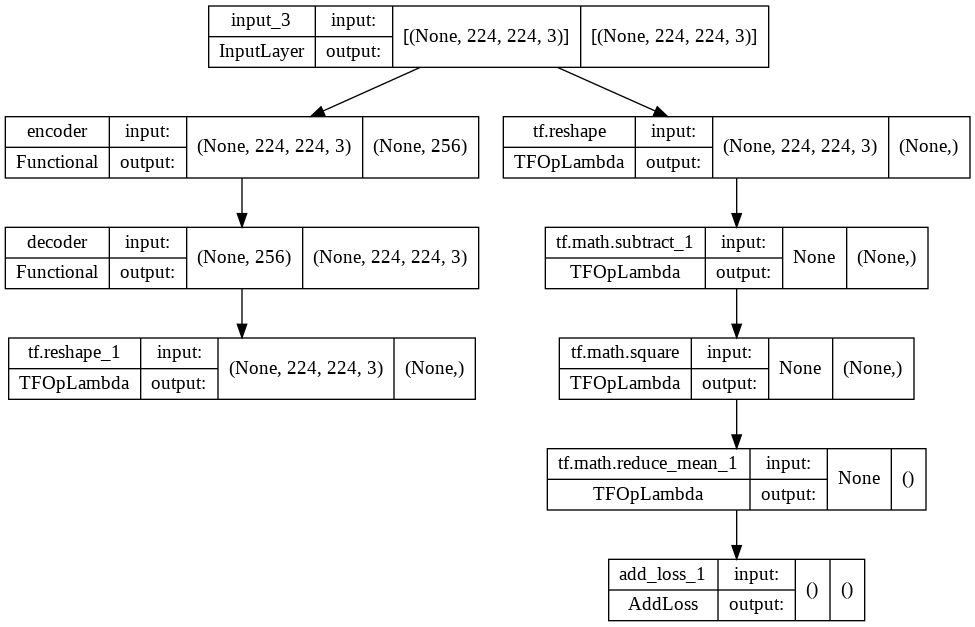

In [ ]:
keras.utils.plot_model(autoencoder, "arch_autoencoder.png", show_shapes = True)
# keras.utils.plot_model(encoder, "arch_encoder.png", show_shapes = True)
# keras.utils.plot_model(decoder, "arch_decoder.png", show_shapes = True)

from google.colab.patches import cv2_imshow
arch = cv2.imread("arch_autoencoder.png")
cv2_imshow(arch)
# arch = cv2.imread("arch_encoder.png")
# cv2_imshow(arch)
# arch = cv2.imread("arch_decoder.png")
# cv2_imshow(arch)

In [ ]:
binary_regularization_loss = 0.01 * keras.backend.mean(
  keras.backend.sum(
    keras.backend.abs(keras.backend.abs(encoder_output) - 1),
    axis = -1
  ),
  axis = -1
)
encoder.add_loss(binary_regularization_loss)
encoder.add_metric(
  binary_regularization_loss, name = "binary_regularization"
)

In [ ]:
autoencoder.add_loss(
  keras.backend.mean(
    keras.backend.square(
      keras.backend.flatten(input) - keras.backend.flatten(decoder_out)
    ),
    axis = -1
  )
)
encoder.compile(
  metrics = [ 'binary_regularization' ]
)
autoencoder.compile(
  optimizer = 'adam'
)

- ##### Restoring the model state to resume training:

In [ ]:
MODEL_DIRECTORY         = os.path.join(PROJECT_DIRECTORY, "models")
MODEL_FILENAME_TEMPLATE = "autoencoder_model_base_{epoch:02d}.h5"
MODEL_FILENAME_REGEX = re.compile(MODEL_FILENAME_TEMPLATE.replace("{epoch:02d}", "(\d+)"))

last_trained_model_file = None
last_trained_model_epoch = 0
for file in os.listdir(MODEL_DIRECTORY):
  match = MODEL_FILENAME_REGEX.match(file)
  if match:
    train_epoch = int(match[1])
    if train_epoch > last_trained_model_epoch:
      last_trained_model_epoch = train_epoch
      last_trained_model_file = file

if last_trained_model_file is not None:
  print(last_trained_model_file)
  autoencoder = keras.models.load_model(
      os.path.join(MODEL_DIRECTORY, last_trained_model_file),
  )
  print(autoencoder.summary())

autoencoder_model_base_32.h5
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 encoder (Functional)           (None, 256)          901472      ['input_3[0][0]']                
                                                                                                  
 decoder (Functional)           (None, 224, 224, 3)  940259      ['encoder[0][0]']                
                                                                                                  
 tf.reshape (TFOpLambda)        (None,)              0           

- ##### Training the model:

In [ ]:
save_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath = os.path.join(MODEL_DIRECTORY, MODEL_FILENAME_TEMPLATE)
)

results = autoencoder.fit(
  train, epochs = 100,
  initial_epoch = last_trained_model_epoch,
  validation_data = validation,
  callbacks = [ save_checkpoint_callback ]
)

In [ ]:
autoencoder.save(os.path.join(PROJECT_DIRECTORY, "autoencoder_base.h5"))
encoder.save(os.path.join(PROJECT_DIRECTORY, "encoder_base.h5"))
decoder.save(os.path.join(PROJECT_DIRECTORY, "decoder_base.h5"))

In [ ]:
encoder     = keras.models.load_model(
    os.path.join(PROJECT_DIRECTORY, "encoder_base.h5"),
    # custom_objects = { 'binary_regularization' },
    compile = False
)
autoencoder = keras.models.load_model(
    os.path.join(PROJECT_DIRECTORY, "autoencoder_base.h5"),
    compile = False
)

- ##### Comparison of Training and Validation Metrics:

In [ ]:
def plot_comparison(results, metric):
  pyplot.title(f"Training vs. Validation " + metric + f" for {len(results.epoch)} epochs")
  pyplot.xlabel("Epoch #")
  pyplot.ylabel(metric.title())
  pyplot.plot(results.history[metric], label = "Training "+metric.title())
  pyplot.plot(results.history['val_'+metric], label = "Validation "+metric.title())
  pyplot.legend()

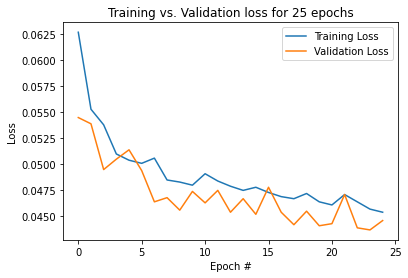

In [ ]:
plot_comparison(results, 'loss')

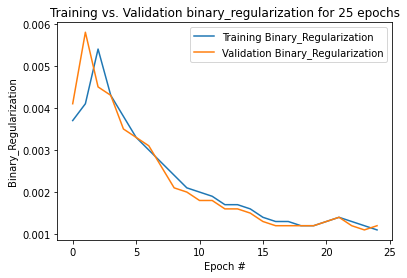

In [ ]:
plot_comparison(results, "binary_regularization")

- ##### Sample Predictions

In [ ]:
!ls "/content/images/base/train/0"

In [ ]:
image = keras.preprocessing.image.load_img(
    "/content/images/base/train/0/15403.jpg",
    target_size = (224, 224)
)
input_arr = keras.preprocessing.image.img_to_array(image) / 255
outimage = numpy.array([ input_arr ])
outimage = autoencoder.predict(outimage)
# pyplot.imshow(Image.fromarray(outimage[0]))
outimage.shape

(1, 224, 224, 3)

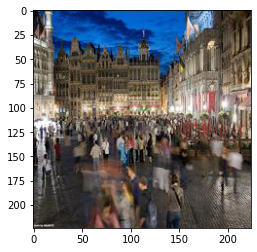

In [ ]:
pyplot.imshow(input_arr)

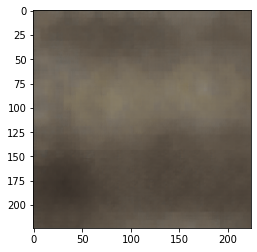

In [ ]:
pyplot.imshow(Image.fromarray((outimage[0] * 255).astype(numpy.uint8)))

In [ ]:
test_results = autoencoder.evaluate(test)

2500/2500 [==============================] - 329s 127ms/step - loss: 0.0425 - binary_regularization: 0.0022


In [ ]:
print(f"Test Loss: {test_results[0]:.6f}")
print(f"Test Binary_Regularization: {test_results[1]:.6f}")

Test Loss: 0.042489
Test Binary_Regularization: 0.002178


## Building the Alternative Model:

In [ ]:
base_model = keras.applications.MobileNetV2(
    input_shape = IMAGE_SHAPE,
    weights = 'imagenet', include_top = False,
    pooling = 'avg'
)

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
train, test, validation = get_datasets("base", augment = False, batch_sizes = (16, 8, 8))

Found 60000 images belonging to 1 classes.
Found 20000 images belonging to 1 classes.
Found 20000 images belonging to 1 classes.


In [ ]:
class ModelProcessedSequence(keras.utils.Sequence):
    def __init__(self, generator):
        self.generator = generator

    def __len__(self):
        return len(self.generator)

    def __getitem__(self, idx):
        batch_x, batch_y = next(self.generator)
        fv_x = base_model.predict_on_batch(batch_x)
        fv_y = base_model.predict_on_batch(batch_y)
        return (fv_x, fv_y)

def to_feature_vectors(generator):
  return ModelProcessedSequence(generator)

In [ ]:
train_fv = to_feature_vectors(train)
test_fv = to_feature_vectors(test)
validation_fv = to_feature_vectors(validation)

- ##### Building the autoencoder to constrain feature vectors to a lower dimension:

In [ ]:
def build_feature_autoencoder():
  keras.backend.clear_session()
  encoder_input = keras.layers.Input(shape = base_model.output.shape[1:])
  sub_layer = encoder_input
  # sub_layer = keras.layers.Dense(1024, activation = 'tanh')(sub_layer)
  sub_layer = keras.layers.Dense(512, activation = 'tanh')(sub_layer)
  encoder_output = keras.layers.Dense(HASH_SIZE, activation = 'tanh')(sub_layer)
  encoder = keras.Model(
    name = "encoder",
    inputs = encoder_input, outputs = encoder_output
  )
  binary_regularization_loss = 0.01 * keras.backend.mean(
    keras.backend.sum(
      keras.backend.abs(keras.backend.abs(encoder_output) - 1),
      axis = -1
    ),
    axis = -1
  )
  encoder.add_loss(binary_regularization_loss)
  encoder.add_metric(
    binary_regularization_loss, name = "binary_regularization"
  )

  decoder_input = keras.layers.Input((HASH_SIZE, ))
  sub_layer = keras.layers.Dense(512, activation = 'tanh')(decoder_input)
  # sub_layer = keras.layers.Dense(1024, activation = 'tanh')(sub_layer)
  decoder_output = keras.layers.Dense(base_model.output.shape[-1], activation = 'tanh')(sub_layer)
  decoder = keras.Model(
    name = "decoder",
    inputs = decoder_input, outputs = decoder_output
  )

  return encoder, decoder

In [ ]:
encoder, decoder = build_feature_autoencoder()
encoder.summary()
decoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1280)]       0           []                               
                                                                                                  
 dense (Dense)                  (None, 512)          655872      ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 256)          131328      ['dense[0][0]']                  
                                                                                                  
 tf.math.abs (TFOpLambda)       (None, 256)          0           ['dense_1[0][0]']                
                                                                                            

In [ ]:
input = keras.layers.Input(shape = base_model.output.shape[1:])
encoder_out = encoder(input)
decoder_out = decoder(encoder_out)
autoencoder = keras.Model(inputs = input, outputs = decoder_out)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1280)]            0         
                                                                 
 encoder (Functional)        (None, 256)               787200    
                                                                 
 decoder (Functional)        (None, 1280)              788224    
                                                                 
Total params: 1,575,424
Trainable params: 1,575,424
Non-trainable params: 0
_________________________________________________________________


In [ ]:
autoencoder.add_loss(
  keras.backend.mean(
    keras.backend.square(
      keras.backend.flatten(input) - keras.backend.flatten(decoder_out)
    ),
    axis = -1
  )
)
encoder.compile(
  metrics = [ 'binary_regularization' ]
)
autoencoder.compile(
  optimizer = 'adam'
)

In [ ]:
MODEL_DIRECTORY         = os.path.join(PROJECT_DIRECTORY, "models_alt")
MODEL_FILENAME_TEMPLATE = "autoencoder_model_base_{epoch:02d}.h5"
MODEL_FILENAME_REGEX = re.compile(MODEL_FILENAME_TEMPLATE.replace("{epoch:02d}", "(\d+)"))

last_trained_model_file = None
last_trained_model_epoch = 0
for file in os.listdir(MODEL_DIRECTORY):
  match = MODEL_FILENAME_REGEX.match(file)
  if match:
    train_epoch = int(match[1])
    if train_epoch > last_trained_model_epoch:
      last_trained_model_epoch = train_epoch
      last_trained_model_file = file

if last_trained_model_file is not None:
  print(last_trained_model_file)
  autoencoder = keras.models.load_model(
      os.path.join(MODEL_DIRECTORY, last_trained_model_file),
  )
  print(autoencoder.summary())

autoencoder_model_base_03.h5
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 1280)]       0           []                               
                                                                                                  
 encoder (Functional)           (None, 256)          787200      ['input_3[0][0]']                
                                                                                                  
 decoder (Functional)           (None, 1280)         788224      ['encoder[0][0]']                
                                                                                                  
 tf.reshape (TFOpLambda)        (None,)              0           ['input_3[0][0]']                
                                                                 

- ##### Training the model:

In [ ]:
save_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath = os.path.join(MODEL_DIRECTORY, MODEL_FILENAME_TEMPLATE)
)

results = autoencoder.fit(
  train_fv, epochs = 25,
  initial_epoch = last_trained_model_epoch,
  validation_data = validation_fv,
  callbacks = [ save_checkpoint_callback ]
)

Epoch 4/25
  71/3750 [..............................] - ETA: 58:48 - loss: 0.3436 - binary_regularization: 8.9968e-09

In [ ]:
autoencoder.save(os.path.join(PROJECT_DIRECTORY, "autoencoder_alt_base.h5"))
encoder.save(os.path.join(PROJECT_DIRECTORY, "encoder_alt_base.h5"))
decoder.save(os.path.join(PROJECT_DIRECTORY, "decoder_alt_base.h5"))

In [ ]:
encoder     = keras.models.load_model(
    os.path.join(PROJECT_DIRECTORY, "encoder_alt_base.h5"),
)
autoencoder = keras.models.load_model(
    os.path.join(PROJECT_DIRECTORY, "autoencoder_alt_base.h5"),
)

- ##### Comparison of training and validation metrics

In [ ]:
def plot_comparison(results, metric):
  pyplot.title(f"Training vs. Validation " + metric + f" for {len(results.epoch)} epochs")
  pyplot.xlabel("Epoch #")
  pyplot.ylabel(metric.title())
  pyplot.plot(results.history[metric], label = "Training "+metric.title())
  pyplot.plot(results.history['val_'+metric], label = "Validation "+metric.title())
  pyplot.legend()

In [ ]:
plot_comparison(results, "loss")

In [ ]:
plot_comparison(results, "binary_regularization")

## Using the model for Image Retrieval

In [ ]:
def get_hash(encoder, image_path, debug = False):
  image = Image.open(image_path)
  image_array = numpy.array(image) / 255
  image_fv = base_model.predict(numpy.array([ image_array ]))
  hash_vector = encoder.predict(image_fv)
  hash_vector = hash_vector[0]
  if debug: print(hash_vector)
  hash = 0
  for bit in hash_vector:
    hash |= (1 if bit > 0 else 0)
    hash <<= 1
  return hash

In [ ]:
def get_similarity_score(hash1, hash2):
  return bin(hash1 ^ hash2).count("1")

In [ ]:
image_files = os.listdir("/content/images/base/test/0/")

In [ ]:
hash = get_hash(
  encoder, os.path.join("/content/images/base/test/0/", image_files[0]),
  debug = True
)
print(f"{hash:X}")

[ 1.          1.          1.         -1.          1.          1.
  1.          1.          1.         -1.         -1.          1.
  1.          1.         -1.         -0.9999997   1.         -0.9999997
  1.         -1.         -1.          1.          1.          1.
  1.          1.          1.          1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.          1.
  1.          1.         -1.          1.         -0.9999997  -1.
  1.          1.         -1.         -1.          1.          1.
  1.         -1.         -1.         -1.         -1.         -1.
 -1.          1.          1.          1.         -1.          1.
 -1.         -1.         -1.          1.         -1.         -0.9999997
 -1.         -1.          0.99999964 -1.          1.          1.
 -1.          1.          1.          1.         -1.          1.
  1.          1.         -1.          1.         -1.         -0.9999998
  1.         -1.          1.         -1.         -1.          1.
  1.

In [ ]:
hashes = [ hash ]
for image in tqdm.tqdm(image_files[1:]):
  hashes.append(get_hash(encoder, os.path.join("/content/images/base/test/0/", image)))

100%|██████████| 19999/19999 [29:57<00:00, 11.13it/s]


In [ ]:
with open(os.path.join(PROJECT_DIRECTORY, "test_base_hashes.txt"), "w+") as file:
  for hash in hashes: file.write(f"{hash:X}")

In [ ]:
with open(os.path.join(PROJECT_DIRECTORY, "test_base_hashes.txt"), "r+") as file:
  hashes = [ int(hash, 16) for hash in file ]

In [ ]:
SEARCH_INDEX = 5
search_image_hash = hashes[SEARCH_INDEX]
distances = [ get_similarity_score(search_image_hash, other_hash) for other_hash in hashes ]
indices   = numpy.argsort(distances)

IndexError: ignored

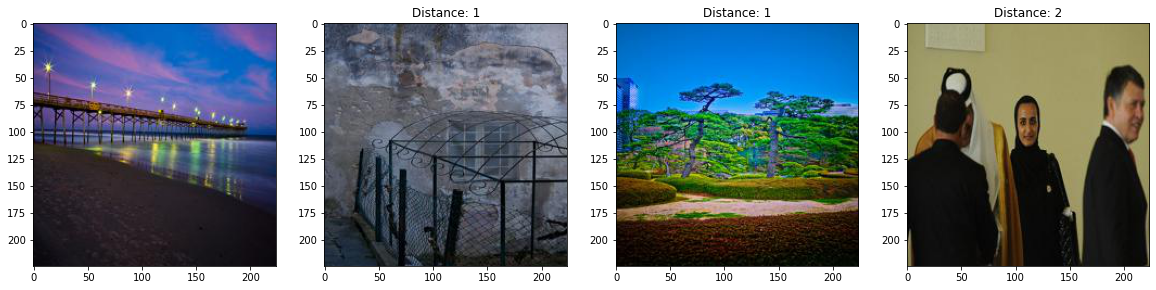

In [ ]:
pyplot.figure(figsize = (20, 8))
pyplot.subplot(1, 4, 1)
pyplot.imshow(Image.open(os.path.join("/content/images/base/test/0/", image_files[SEARCH_INDEX])))
for i in range(1, 4):
  pyplot.subplot(1, 4, i+1)
  pyplot.title(f"Distance: {distances[indices[i]]}")
  pyplot.imshow(Image.open(os.path.join("/content/images/base/test/0/", image_files[indices[i]])))